In [1]:
import osmnx as ox
import pandana
import geopandas as gpd
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

In [2]:
# Select city and crs
cityname = 'warsaw, poland'
crs = 3035

In [3]:
# Get graph by geocoding
graph = ox.graph_from_place(cityname, network_type="walk")

# Project graph
graph = ox.projection.project_graph(graph, to_crs=crs)

In [4]:
# Select points of interest based on osm tags
tags = {
    'amenity':[
        'cafe',
        'bar',
        'pub',
        'restaurant'
    ],
    'shop':[
        'bakery',
        'convenience',
        'supermarket',
        'mall',
        'department_store',
        'clothes',
        'fashion',
        'shoes'
    ],
    'leisure':[
        'fitness_centre'
    ]
}

# Get amentities from place
pois = ox.geometries.geometries_from_place(cityname, tags=tags)
    
# Project pois
pois = pois.to_crs(epsg=crs)

In [5]:
# Max time to walk in minutes (no routing to nodes further than this)
walk_time = 15

# Walking speed
walk_speed = 4.5

# Set a uniform walking speed on every edge
for u, v, data in graph.edges(data=True):
    data['speed_kph'] = walk_speed
graph = ox.add_edge_travel_times(graph)

# Extract node/edge GeoDataFrames, retaining only necessary columns (for pandana)
nodes = ox.graph_to_gdfs(graph, edges=False)[['x', 'y']]
edges = ox.graph_to_gdfs(graph, nodes=False).reset_index()[['u', 'v', 'travel_time']]

In [6]:
# Construct the pandana network model
network = pandana.Network(
    node_x=nodes['x'],
    node_y=nodes['y'], 
    edge_from=edges['u'],
    edge_to=edges['v'],
    edge_weights=edges[['travel_time']]
)

# Extract centroids from the pois' geometries
centroids = pois.centroid

Generating contraction hierarchies with 16 threads.
Setting CH node vector of size 185525
Setting CH edge vector of size 542678
Range graph removed 547704 edges of 1085356
. 10% . 20% . 30% . 40% . 50% . 60% . 70% . 80% . 90% . 100%


In [7]:
# Specify a max travel distance for analysis
# Minutes -> seconds
maxdist = walk_time * 60

# Set the pois' locations on the network
network.set_pois(
    category='pois',
    maxdist=maxdist,
    maxitems=10,
    x_col=centroids.x, 
    y_col=centroids.y
)

/home/eemil/miniconda3/envs/gisnw/lib/python3.9/site-packages/pandana/network.py:660: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  elif isinstance(maxitems, type(pd.Series())):
/home/eemil/miniconda3/envs/gisnw/lib/python3.9/site-packages/pandana/network.py:668: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  elif isinstance(maxdist, type(pd.Series())):


In [8]:
# calculate travel time to 10 nearest pois from each node in network
distances = network.nearest_pois(
    distance=maxdist,
    category='pois',
    num_pois=10
)

distances.astype(int).head()

,1,2,3,4,5,6,7,8,9,10
osmid,,,,,,,,,,
26063726,289,417,539,560,585,599,618,625,666,729
270313043,268,396,519,540,564,578,597,604,681,709
339919532,295,437,560,581,605,606,638,645,646,709
4404880725,304,432,554,575,600,614,633,639,681,744
26063729,219,250,353,558,564,604,639,668,685,717


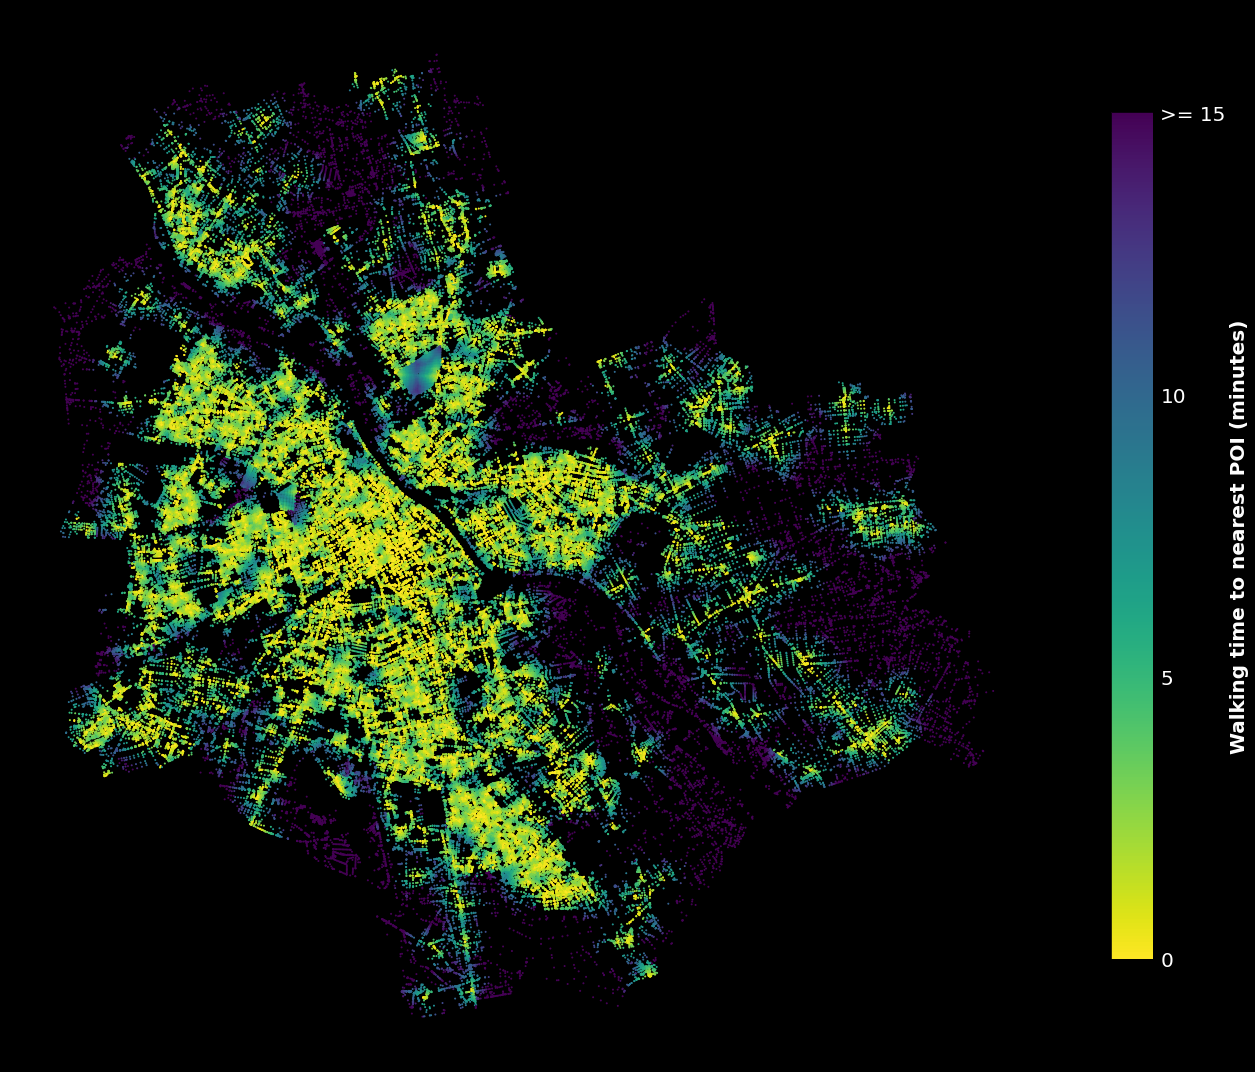

In [9]:
# Set text parameters
COLOR = 'white'
plt.rcParams['text.color'] = COLOR
plt.rcParams['axes.labelcolor'] = COLOR
plt.rcParams['xtick.color'] = COLOR
plt.rcParams['ytick.color'] = COLOR

# Setup plot
fig, ax = plt.subplots(figsize=(20,15))
ax.set_axis_off()
ax.set_aspect('equal')
fig.set_facecolor((0,0,0))

# Plot distance to nearest POI
sc = ax.scatter(
    x=nodes['x'],
    y=nodes['y'], 
    c=distances[1],
    s=1,
    cmap='viridis_r',
)

# Colorbar
cb = fig.colorbar(sc, ax=ax, shrink=0.8, ticks=[0, 300, 600, 900])
cb.ax.tick_params(color='none', labelsize=20)
cb.ax.set_yticklabels(['0', '5', '10', '>= 15'])
cb.set_label('Walking time to nearest POI (minutes)', fontsize=20, fontweight='bold')

# Remove empty space
plt.tight_layout()

# Save
plt.savefig('./docs/walk_access.png')

/tmp/ipykernel_10777/1042402413.py:71: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


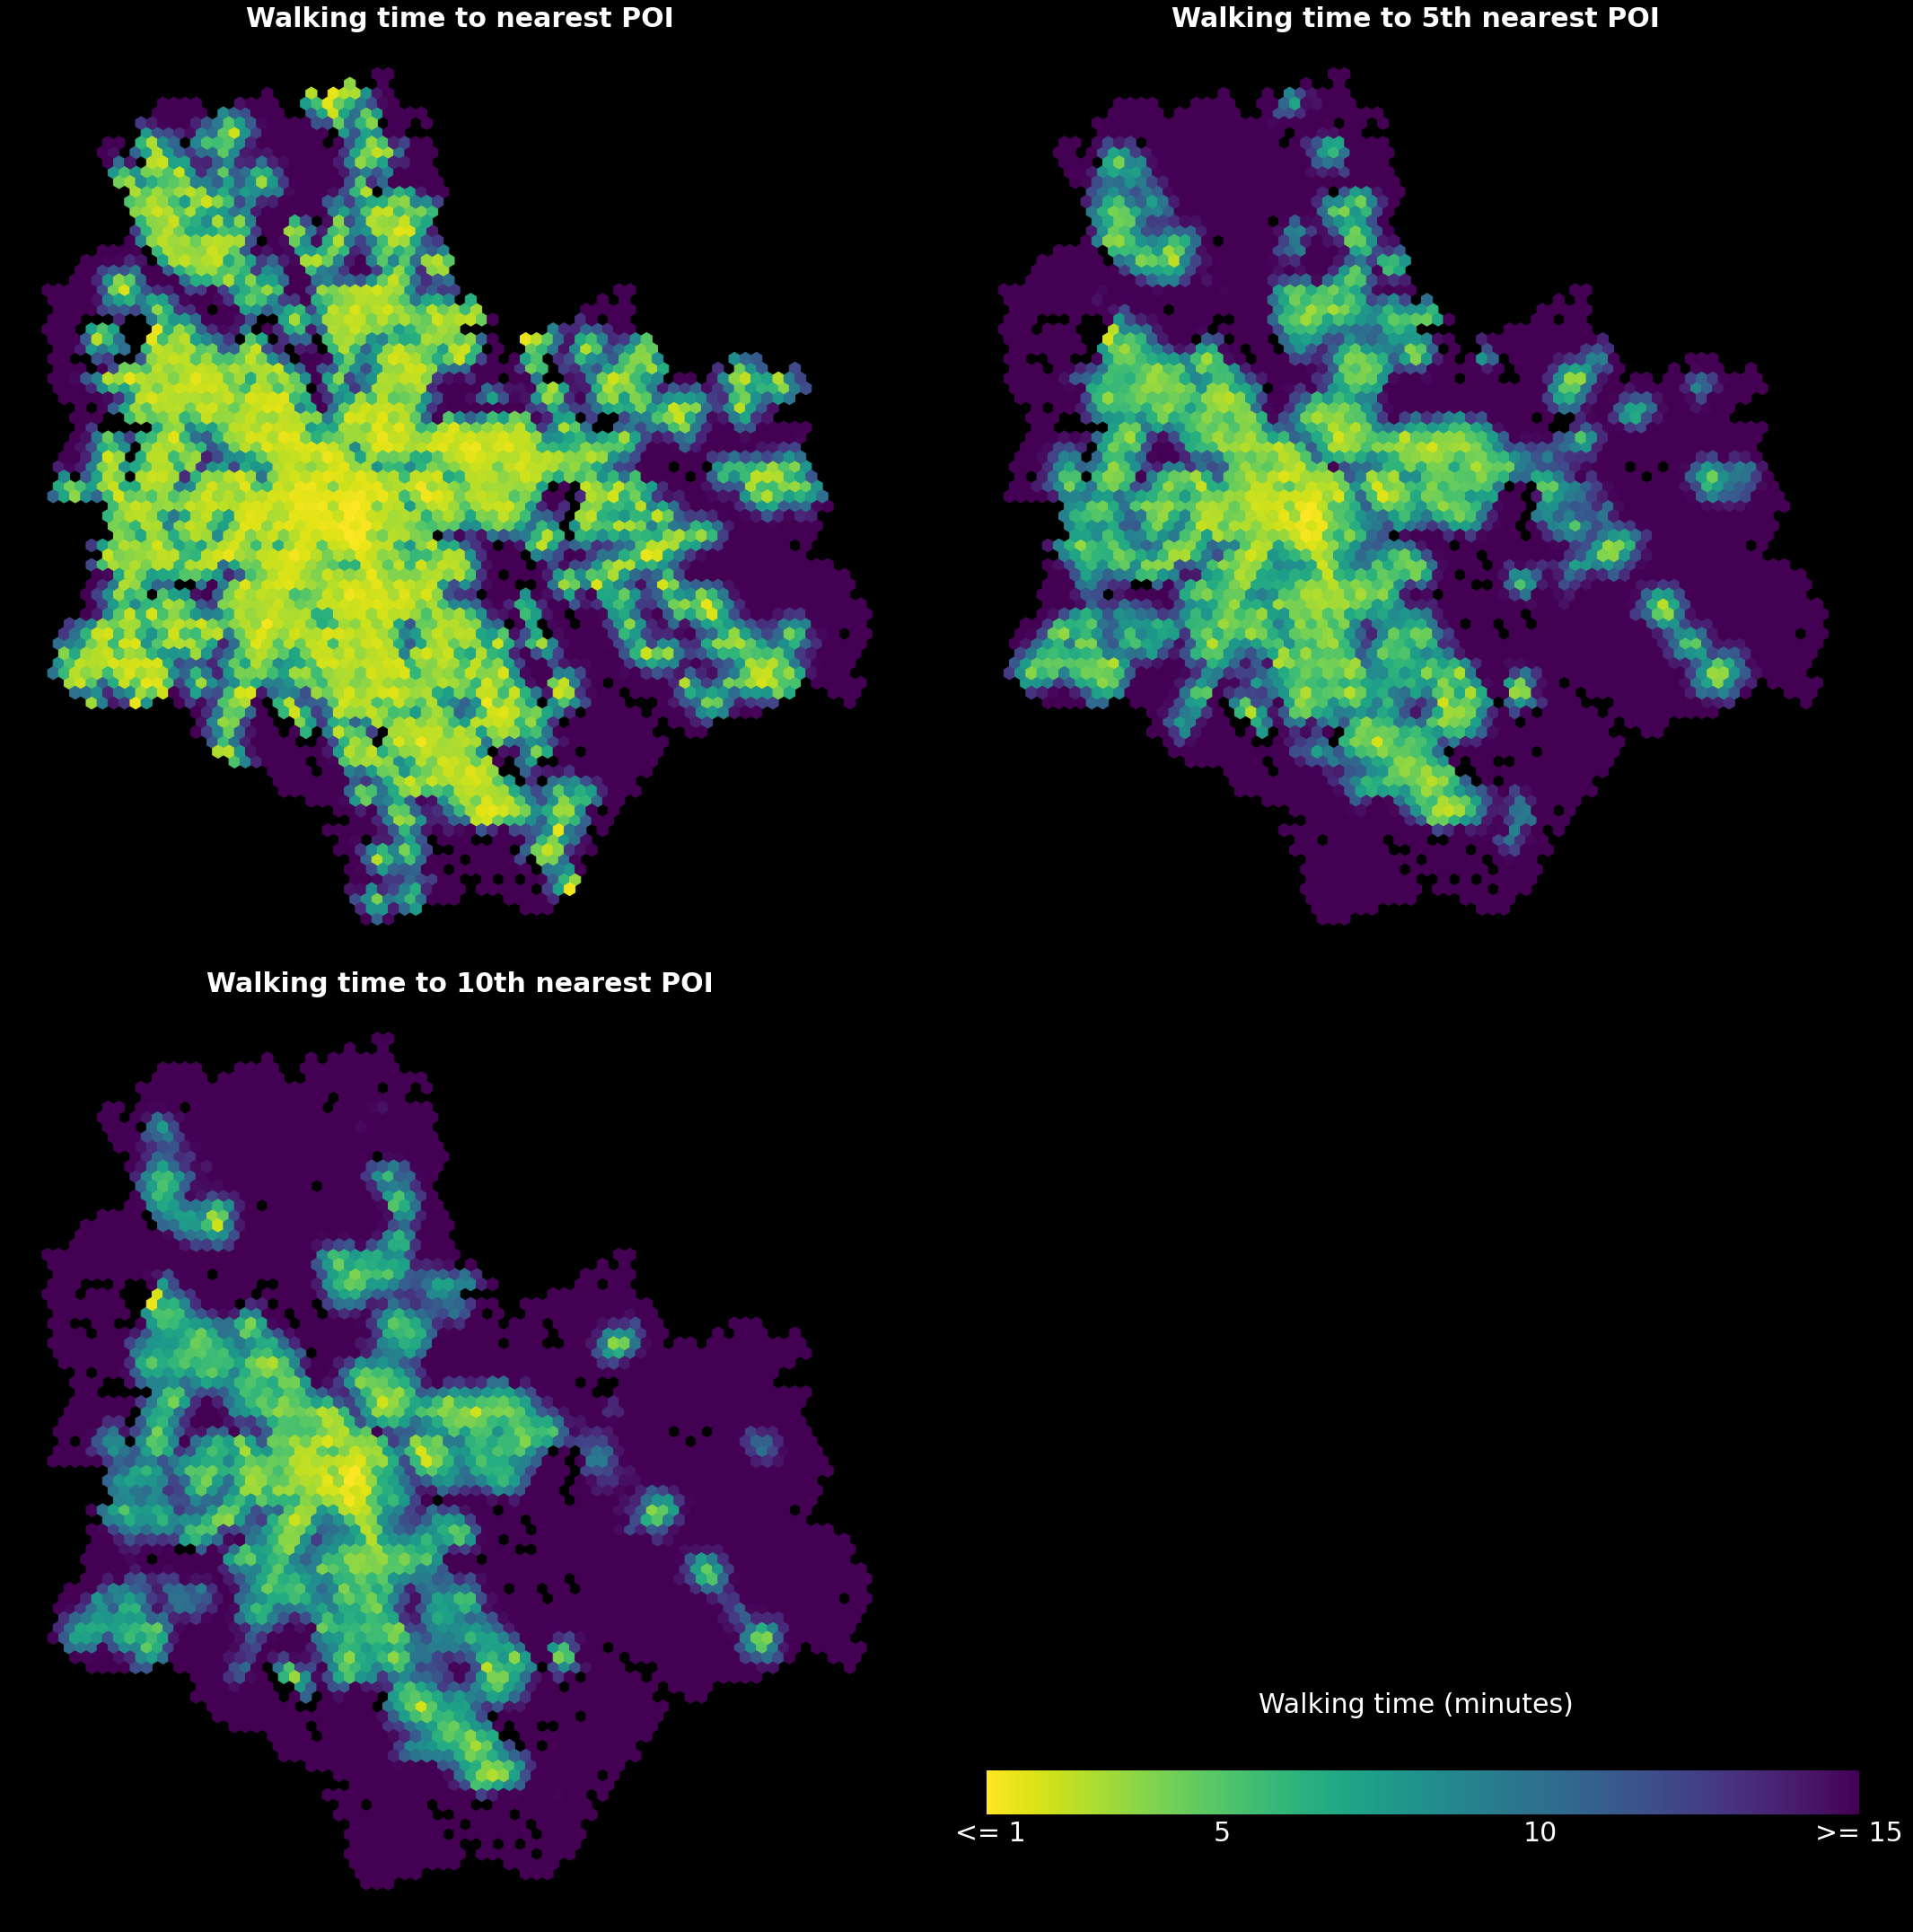

In [10]:
# Setup plot
fig, ax = plt.subplots(nrows=2, ncols=2, figsize=(30,30), constrained_layout=False)
ax[0][0].set_axis_off()
ax[0][1].set_axis_off()
ax[1][0].set_axis_off()
ax[1][1].set_axis_off()
ax[0][0].set_aspect('equal')
ax[0][1].set_aspect('equal')
ax[1][0].set_aspect('equal')

# Specify colors
fig.set_facecolor('black')
cmap = 'viridis_r'

# Plot distance to nearest POI
hb = ax[0][0].hexbin(
    x=nodes['x'],
    y=nodes['y'],
    gridsize=75,
    cmap=cmap,
    C=distances[1],
    alpha=1
)

# Plot distance to 5th nearest POI
hb = ax[0][1].hexbin(
    x=nodes['x'],
    y=nodes['y'],
    gridsize=75,
    cmap=cmap,
    C=distances[5],
    alpha=1
)

# Plot distance to 10th nearest POI
hb = ax[1][0].hexbin(
    x=nodes['x'],
    y=nodes['y'],
    gridsize=75,
    cmap=cmap,
    C=distances[10],
    alpha=1
)

# Add titles to maps
ax[0][0].set_title('Walking time to nearest POI', fontsize=30, fontweight='bold')
ax[0][1].set_title('Walking time to 5th nearest POI', fontsize=30, fontweight='bold')
ax[1][0].set_title('Walking time to 10th nearest POI', fontsize=30, fontweight='bold')

# Setup color bar axis (location of color bar)
cbar_ax = fig.add_axes([0.5, 0.01, 0.5, 0.5])
cbar_ax.set_axis_off()

# Color bar properties
cb = plt.colorbar(
    hb,
    ax=cbar_ax,
    shrink=0.9,
    ticks=[82, 300, 600, 900],
    orientation='horizontal',
    aspect=20
)
cb.outline.set_edgecolor('none')
cb.ax.tick_params(color='none', labelsize=30)
cb.ax.set_xticklabels(['<= 1', '5', '10', '>= 15'])

# Title for color bar
ax[1][1].text(0.5, 0.23, 'Walking time (minutes)', fontsize=30, ha='center')

# Tight layout
plt.tight_layout()

# Save
plt.savefig('./docs/walk_access_comparison.png')

In [11]:
# check data
distances.head()

,1,2,3,4,5,6,7,8,9,10
osmid,,,,,,,,,,
26063726,289.100006,417.299988,539.900024,560.900024,585.400024,599.400024,618.200012,625.000000,666.299988,729.799988
270313043,268.500000,396.700012,519.299988,540.299988,564.799988,578.799988,597.599976,604.400024,681.200012,709.599976
339919532,295.899994,437.500000,560.099976,581.099976,605.599976,606.200012,638.400024,645.200012,646.099976,709.599976
4404880725,304.000000,432.200012,554.799988,575.799988,600.299988,614.299988,633.099976,639.900024,681.200012,744.700012
26063729,219.899994,250.399994,353.799988,558.099976,564.999023,604.400024,639.299988,668.400024,685.098999,717.000000


In [12]:
nodes.head()

,x,y
osmid,,
26063726,5.071758e+06,3.283941e+06
270313043,5.071762e+06,3.283915e+06
339919532,5.071733e+06,3.283946e+06
4404880725,5.071748e+06,3.283957e+06
26063729,5.071946e+06,3.282803e+06


In [13]:
# Get nodes with wgs coords for output csv
graph_wgs = ox.projection.project_graph(graph, to_crs=4326)
nodes_wgs = ox.graph_to_gdfs(graph_wgs, edges=False)[['x', 'y']]

In [14]:
# Join travel time info to nodes
walk_access = nodes.join(distances, on='osmid', how='left')
walk_access_wgs = nodes_wgs.join(distances, on='osmid', how='left')

In [15]:
walk_access_wgs.head()

,x,y,1,2,3,4,5,6,7,8,9,10
osmid,,,,,,,,,,,,
26063726,21.017454,52.152787,289.100006,417.299988,539.900024,560.900024,585.400024,599.400024,618.200012,625.000000,666.299988,729.799988
270313043,21.017454,52.152555,268.500000,396.700012,519.299988,540.299988,564.799988,578.799988,597.599976,604.400024,681.200012,709.599976
339919532,21.017106,52.152863,295.899994,437.500000,560.099976,581.099976,605.599976,606.200012,638.400024,645.200012,646.099976,709.599976
4404880725,21.017353,52.152943,304.000000,432.200012,554.799988,575.799988,600.299988,614.299988,633.099976,639.900024,681.200012,744.700012
270196787,21.017454,52.152340,249.399994,415.799988,538.400024,559.400024,559.700012,583.900024,616.700012,623.500000,690.500000,700.299988


In [16]:
# Save as CSV
walk_access_wgs.to_csv('./data/walk_access.csv', encoding='utf-8')